In [2]:
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LinearSegmentedColormap

project_root = os.path.abspath(os.path.join(os.getcwd()))
if project_root not in sys.path:
    sys.path.append(project_root)

EXAMPL_TOKENS = ['I', 'went', 'to', 'school', '.']
CUSTOM_CMAP = LinearSegmentedColormap.from_list('', ['gainsboro', 'red'])


In [148]:

def get_random_graph(num_tokens, num_layers):
    G = nx.Graph()

    layer_pos_fac = 2.5
    token_pos_fac = 2.5
    module_pos_fac = 1

    # Add nodes
    for token_pos in range(num_tokens):
        G.add_node(f'emb.{token_pos}', pos=(token_pos * token_pos_fac, 0), type='emb')
        for layer_id in range(1, num_layers + 1):
            for i, module in enumerate(['attn', 'mlp']):
                curr_node = f"{layer_id}.{module}.{token_pos}"
                curr_pos = (token_pos * token_pos_fac,layer_id * layer_pos_fac + i * module_pos_fac)
                G.add_node(curr_node, pos=curr_pos, type=module)

    G.add_node(f'target', pos=((token_pos + 1) * token_pos_fac, ((layer_id + 1) * layer_pos_fac)), type='target')

    # add edges
    node_queue = [list(G.nodes(data=True))[-1]]

    while node_queue:
        curr_node, curr_data = node_queue.pop(0)
        curr_pos = curr_data['pos']

        if curr_node == 'target':
            valid_nodes = [(node, data) for node, data in G.nodes(data=True) if data['pos'][0] == (curr_pos[0] - token_pos_fac) and data['pos'][1] < curr_pos[1]]
            num_edges = 10
        else:
            valid_nodes = [(node, data) for node, data in G.nodes(data=True) if data['pos'][0] <= curr_pos[0] and data['pos'][1] < curr_pos[1]]
            num_edges = int(random.random() * (curr_pos[0] / token_pos_fac + curr_pos[0] / layer_pos_fac ))
        edge_nodes = random.sample(valid_nodes, k=min([num_edges, len(valid_nodes)]))
        for node, data in edge_nodes:
            G.add_edge(curr_node, node, weight=round(random.random(), 2), is_same_token = data['pos'][0] == curr_pos[0])
        node_queue.extend(edge_nodes)

    return G

In [31]:
from dataclasses import dataclass

@dataclass
class ContributionTracePlotConfig:

    # label spaces
    x_label_space = 2
    y_label_space = 3

    # node shapes
    emb_node_shape='o'
    attn_node_shape='s'
    mlp_node_shape='d'
    target_node_shape='^'

    # node colors
    emb_node_color='gold'
    attn_node_color='skyblue'
    mlp_node_color='orange'
    target_node_color='red'

    # node sizes
    node_size=150,
    target_node_size=200

    # edge conf
    edge_width = 0.5
    show_edge_arrows = True
    edge_arrow_style = '<-'
    edge_cmap = CUSTOM_CMAP
    


In [29]:
def plot_contribution_trace(graph, tokens, num_layers, num_tokens, **kwargs):
    
    # adjust positions
    conf = ContributionTracePlotConfig(**kwargs)

    pos = nx.get_node_attributes(graph, 'pos')
    plot_adjusted_pos = {node_key: (x_pos + conf.y_label_space, y_pos + conf.x_label_space) for node_key, (x_pos, y_pos) in pos.items()}

    # create node groups:
    node_groups = []
    emb_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'emb']
    node_groups.append({"nodelist": emb_nodes, "node_shape": conf.emb_node_shape, 'node_color': conf.emb_node_color, 'node_size': conf.node_size })

    attn_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'attn']
    node_groups.append({"nodelist": attn_nodes, "node_shape": conf.attn_node_shape, 'node_color': conf.attn_node_color, 'node_size': conf.node_size })

    mlp_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'mlp']
    node_groups.append({"nodelist": mlp_nodes, "node_shape": conf.mlp_node_shape, 'node_color': conf.mlp_node_color, 'node_size': conf.node_size })

    target_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 'target']
    node_groups.append({"nodelist": target_nodes, "node_shape": conf.target_node_shape, 'node_color': conf.target_node_color, 'node_size': conf.target_node_size })

    # create edge groups
    edge_groups = []
    dif_tok_edges = [((_from, _to), data['weight']) for _from, _to, data in graph.edges(data=True) if not data['is_same_token']]
    if dif_tok_edges:
        edges, weights = zip(*dif_tok_edges)
        edge_groups.append({"edgelist": edges, "edge_color": weights, "connectionstyle": 'arc,angleA=0,angleB=180,armA=30,armB=30,rad=30'})

    same_tok_edges = [((_from, _to), data['weight']) for _from, _to, data in graph.edges(data=True) if data['is_same_token']]
    if same_tok_edges:
        edges, weights = zip(*same_tok_edges)
        edge_groups.append({"edgelist": edges, "edge_color": weights, "connectionstyle": 'arc3,rad=0.3'})

    # initiate figure 
    x_pos, y_pos = graph.nodes['target']['pos']
    width = (num_tokens + 1) + (conf.y_label_space) / (x_pos / (num_tokens + 1))
    height = (num_layers + 1) + (conf.x_label_space) / (y_pos / (num_layers + 1))
    plt.figure(figsize=(width, height))

    # draw nodes
    for node_group in node_groups:
        nx.draw_networkx_nodes(graph, plot_adjusted_pos, **node_group)

    # draw edges
    for edge_group in edge_groups:
        nx.draw_networkx_edges(graph, plot_adjusted_pos, 
                            arrowstyle=conf.edge_arrow_style,
                            width=conf.edge_width, 
                            edge_vmin = 0,
                            edge_cmap=conf.edge_cmap,
                            arrows=conf.show_edge_arrows,
                            **edge_group) 

    # add target Label
    x_pos, y_pos = graph.nodes['target']['pos']
    plt.text(x_pos + conf.y_label_space, y_pos + conf.x_label_space -1, 'Target', ha='center')

    # X labels
    layer_pos = [(layer, graph.nodes[f"{layer}.attn.0"]['pos'][1]) for layer in range(1, num_layers + 1)]
    plt.text(0, conf.x_label_space, 'Emb.', va='center')
    for i, pos in layer_pos:
        plt.text(0, conf.x_label_space + pos, f"Layer {i}")

    # Y labels
    token_pos = [graph.nodes[f"1.attn.{token}"]['pos'][0] for token in range(num_tokens)]
    for pos, token in zip(token_pos, tokens):
        plt.text(conf.y_label_space + pos, 0, token, ha='center')
    

    plt.axis('off')
    plt.show()

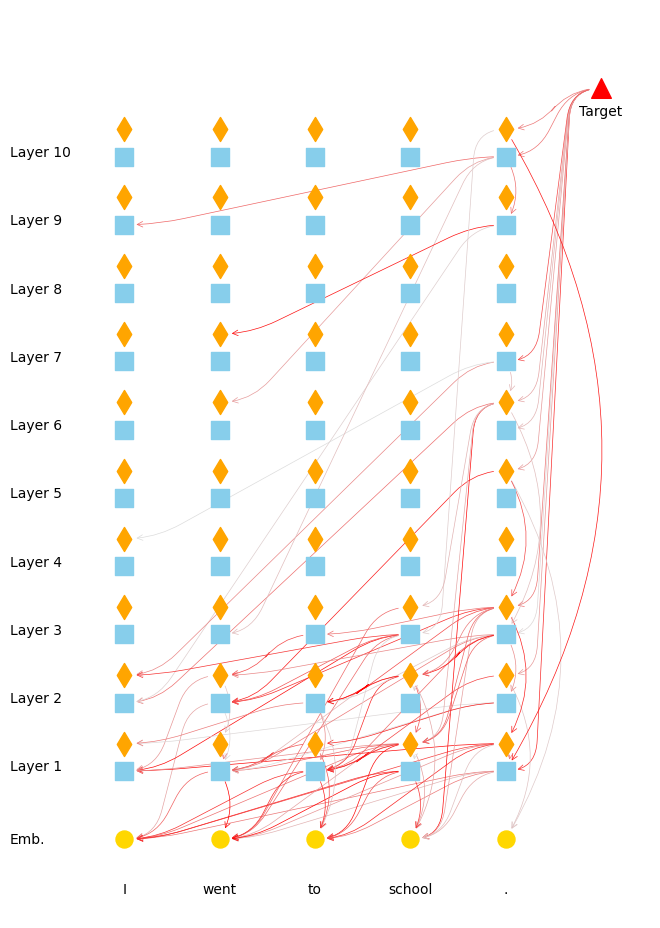

In [155]:
num_tokens = 5
num_layers = 10
tokens = EXAMPL_TOKENS
G = get_random_graph(num_tokens, num_layers)

plot_contribution_trace(G, tokens, num_layers, num_tokens)

In [268]:
from transformers import PretrainedConfig, AutoConfig, AutoTokenizer
from typing import List
import json

model_ids = ["Qwen/Qwen3-4B"]#, "Qwen/Qwen3-8B", "Qwen/Qwen3-14B"]  # "Qwen/Qwen3-0.6B","Qwen/Qwen3-1.7B"
tokenizer = AutoTokenizer.from_pretrained(model_ids[0])
config = AutoConfig.from_pretrained(model_ids[0])

data_path = os.path.join(project_root, 'data/homograph_data/homograph_small.json')
with open(data_path) as f:
    homograph_data = json.load(f) 

def get_module_lookup(model_config: PretrainedConfig, target_layer: int, num_tokens: int) -> List[str]:
    num_attn_heads, attn_head_dim, num_mlp_heads = model_config.num_attention_heads, model_config.head_dim, model_config.intermediate_size
    module_list = ['emb']

    for layer_id in range(target_layer):
        module_list.extend([f"{layer_id}.attn.{token_pos}.{head_pos}" for token_pos in range(num_tokens) for head_pos in range(num_attn_heads * attn_head_dim)])
        module_list.extend([f"{layer_id}.mlp.-1.{head_pos}" for head_pos in range(num_mlp_heads)])
    
    return module_list

module_lookup = get_module_lookup(config, 10, 6)

In [235]:
import pandas as pd
import numpy as np

#TODO we need from and to information + token pos is kind of hard to guess for module lookup (idx does not have an intrisic value) + we should add config etc. to contribution cache
homograph_id = 0
path = f"data/contribution_cache/cache_9_post_with_norm_hom_{homograph_id}.parquet"
df = pd.read_parquet(path)

In [236]:
# add source position
def add_source_module(row):
    source_idx = row['source_idx']
    if np.isnan(source_idx):
        return 'target'
    if source_idx == 0:
        return 'emb'
    module = module_lookup[int(source_idx)]
    layer_id, module_type = module.split('.')[:2]
    return module_type

def add_souce_layer(row):
    source_idx = row['source_idx']
    if np.isnan(source_idx):
        return -1
    if source_idx == 0:
        return -1
    module = module_lookup[int(source_idx)]
    layer_id, module_type = module.split('.')[:2]
    return int(layer_id)

df['source_module_type'] = df.apply(add_source_module,axis=1)
df['source_layer'] = df.apply(add_souce_layer, axis=1)

module_df = df.groupby(['sample_ids', 'source_token_pos', 'token_pos', 'source_layer', 'layer', 'source_module_type', 'module_type'], observed=True)['contribution_values'].sum().reset_index()

In [295]:
df.sort_values('contribution_values')

,contribution_idx,contribution_values,sample_ids,source_idx,source_token_pos,depth,layer,module_type,token_pos,head_id,source_module_type,source_layer
297944,0,-1.055531e+14,2,416.0,0,"[5, 6, 6]",0,emb,0,0,attn,0
297362,0,-2.652572e+13,1,4475.0,1,"[4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6]",0,emb,1,0,attn,0
297943,0,-2.308974e+13,1,416.0,0,"[4, 5, 6, 6]",0,emb,0,0,attn,0
297947,0,-7.765301e+12,5,416.0,0,"[3, 4, 5]",0,emb,0,0,attn,0
297949,0,-2.308545e+11,7,416.0,0,"[4, 5, 5, 6, 6]",0,emb,0,0,attn,0
...,...,...,...,...,...,...,...,...,...,...,...,...
286705,2090,6.168130e+19,2,27325.0,0,"[4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, ...",0,attn,0,2089,mlp,0
286696,433,6.686945e+19,2,27325.0,0,"[4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, ...",0,attn,0,432,mlp,0
286706,2218,6.888706e+19,2,27325.0,0,"[4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, ...",0,attn,0,2217,mlp,0
215000,59264,8.070451e+19,2,94082.0,0,"[4, 4, 4, 5, 5, 5]",1,mlp,0,383,mlp,2


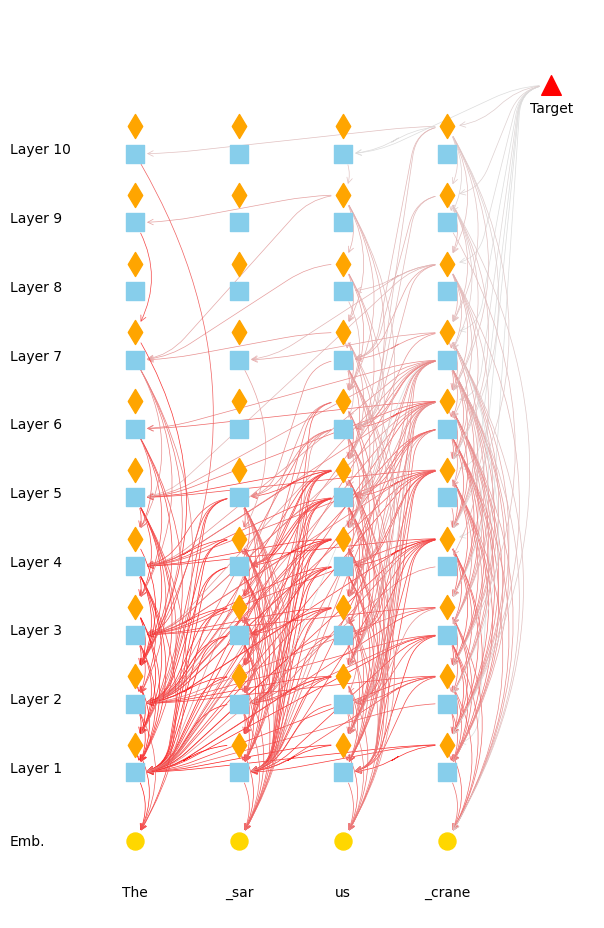

In [292]:
sample_id = 0
sample_df = module_df[module_df['sample_ids'] == sample_id].reset_index(drop=True)
sample_df.head()

num_tokens = sample_df['source_token_pos'].max() + 1
num_layers = sample_df['source_layer'].max() + 1
num_layers, num_tokens

import math
G = nx.Graph()

layer_pos_fac = 2.5
token_pos_fac = 2.5
module_pos_fac = 1

# Add nodes
for token_pos in range(num_tokens):
    G.add_node(f'emb.{token_pos}', pos=(token_pos * token_pos_fac, 0), type='emb')
    for layer_id in range(1, num_layers + 1):
        for i, module in enumerate(['attn', 'mlp']):
            curr_node = f"{layer_id}.{module}.{token_pos}"
            curr_pos = (token_pos * token_pos_fac,layer_id * layer_pos_fac + i * module_pos_fac)
            G.add_node(curr_node, pos=curr_pos, type=module)

G.add_node(f'target', pos=((token_pos + 1) * token_pos_fac, ((layer_id + 1) * layer_pos_fac)), type='target')

# add edges
for i, row in sample_df.iterrows():
    if row['source_module_type'] == 'target':
        source_node = 'target'
    else:
        source_node = f"{row['source_layer'] + 1}.{row['source_module_type']}.{row['source_token_pos']}"
    if row['module_type'] == 'emb':
        target_node = f"{row['module_type']}.{row['token_pos']}"
    else:
        target_node = f"{row['layer'] + 1}.{row['module_type']}.{row['token_pos']}"
    G.add_edge(source_node, target_node, weight=math.log(row['contribution_values']), is_same_token = row['source_token_pos'] == row['token_pos'] and row['source_module_type'] != 'target')

def clean_tokens(tokens):
    return [token.replace('Ġ', '_') for token in tokens]

from data.utils import get_prompts
sample_data = [homograph_data[homograph_id]]
prompts = get_prompts(sample_data, context_type='minimal_context')
tokens = tokenizer.tokenize(prompts[sample_id])
tokens = clean_tokens(tokens)

plot_contribution_trace(G, tokens, num_layers, num_tokens)

In [22]:
import pandas as pd

sample_id = 0
data_path = os.path.join(project_root, f'data/contribution_cache/cache_9_post_bidir_{sample_id}.parquet')
df = pd.read_parquet(data_path)

def process_row(row):

    if row['source'] == 'target':
        source_layer, source_module, source_pos, source_head = 0, 'target', 0, 0
    else:
        source_layer, source_module, source_pos, source_head = row['source'].split('.')
    target_layer, target_module, target_pos, target_head = row['target'].split('.')
    
    return pd.Series({
        'source_module': source_module,
        'source_layer': int(source_layer), 
        'source_pos':int(source_pos), 
        'source_head': int(source_head), 
        'target_module': target_module, 
        'target_layer': int(target_layer), 
        'target_pos': int(target_pos), 
        'target_head': int(target_head)
    })

df[['source_module', 'source_layer', 'source_pos', 'source_head', 'target_module', 'target_layer', 'target_pos', 'target_head']] = df.apply(process_row, axis=1)
df = df.groupby(['source_module', 'source_layer', 'source_pos', 'target_module', 'target_layer', 'target_pos'])['weight'].sum().reset_index()

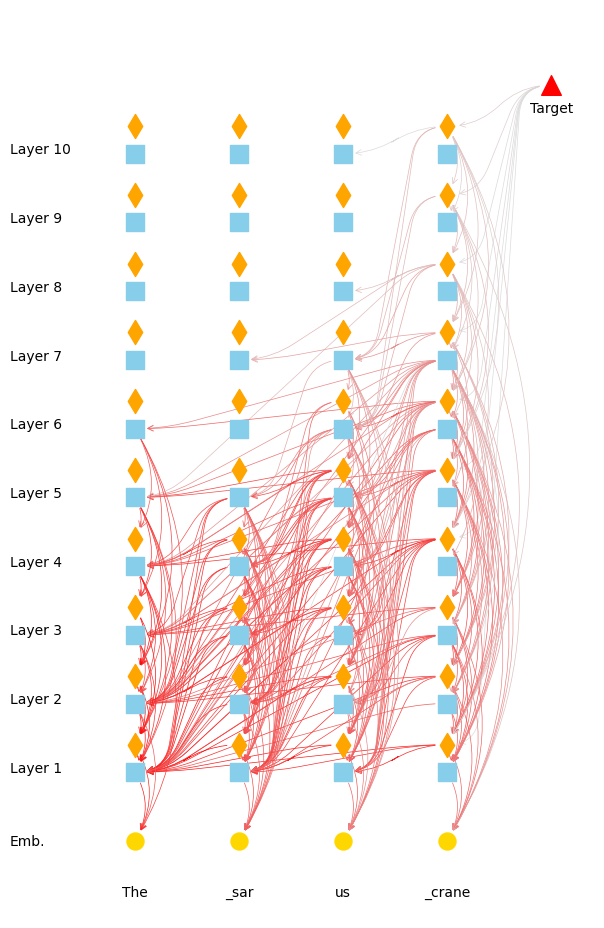

In [32]:
num_tokens = df['source_pos'].max() + 1
num_layers = df['source_layer'].max() + 1
num_layers, num_tokens

import math
G = nx.Graph()

layer_pos_fac = 2.5
token_pos_fac = 2.5
module_pos_fac = 1

# Add nodes
for token_pos in range(num_tokens):
    G.add_node(f'emb.{token_pos}', pos=(token_pos * token_pos_fac, 0), type='emb')
    for layer_id in range(1, num_layers + 1):
        for i, module in enumerate(['attn', 'mlp']):
            curr_node = f"{layer_id}.{module}.{token_pos}"
            curr_pos = (token_pos * token_pos_fac,layer_id * layer_pos_fac + i * module_pos_fac)
            G.add_node(curr_node, pos=curr_pos, type=module)

G.add_node(f'target', pos=((token_pos + 1) * token_pos_fac, ((layer_id + 1) * layer_pos_fac)), type='target')

# add edges
for i, row in df.iterrows():
    if row['source_module'] == 'target':
        source_node = 'target'
    else:
        source_node = f"{row['source_layer'] + 1}.{row['source_module']}.{row['source_pos']}"
    if row['target_module'] == 'emb':
        target_node = f"{row['target_module']}.{row['target_pos']}"
    else:
        target_node = f"{row['target_layer'] + 1}.{row['target_module']}.{row['target_pos']}"
    G.add_edge(source_node, target_node, weight=math.log(row['weight']), is_same_token = row['source_pos'] == row['target_pos'] and row['source_module'] != 'target')

def clean_tokens(tokens):
    return [token.replace('Ġ', '_') for token in tokens]


import json
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B")
data_path = os.path.join(project_root, 'data/homograph_data/homograph_small.json')
with open(data_path) as f:
    homograph_data = json.load(f) 

from data.utils import get_prompts
sample_data = [homograph_data[0]]
prompts = get_prompts(sample_data, context_type='minimal_context')
tokens = tokenizer.tokenize(prompts[0])
tokens = clean_tokens(tokens)

plot_contribution_trace(G, tokens, num_layers, num_tokens)